In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import matplotlib.pyplot as plt
from pprint import pp
from statsmodels.tsa.statespace.varmax import VARMAX

In [2]:
# Import and clean data
newspaper_df = pd.read_csv("news_sent_over_time.csv", keep_default_na=False)
newspaper_df.rename({"published_date": "date"}, inplace=True, axis=1)
print(f'{newspaper_df["date"].max() = }')
newspaper_df.rename({"NEGATIVE": "negative_news",
                     "POSITIVE": "positive_news"}, inplace=True, axis=1)
print(newspaper_df.shape)
print(newspaper_df.head())

debates_df = pd.read_csv("speeches_per_date.csv", keep_default_na=False)
debates_df.rename({"NEGATIVE": "negative_debate",
                     "POSITIVE": "positive_debate"}, inplace=True, axis=1)
print(debates_df.shape)
print(debates_df.head())

newspaper_df["date"].max() = '2023-02-20'
(463, 3)
         date  negative_news  positive_news
0  2021-11-01              5              1
1  2021-11-02              5              1
2  2021-11-03              3              0
3  2021-11-04              4              2
4  2021-11-05              5              1
(488, 3)
         date  negative_debate  positive_debate
0  2021-11-01                1                1
1  2021-11-02                0                1
2  2021-11-03                2                4
3  2021-11-04                0                1
4  2021-11-05                0                0


In [3]:
merged_df = newspaper_df.merge(
    debates_df, on="date", how="left")

merged_df.set_index("date", inplace=True)

print(merged_df.head())

            negative_news  positive_news  negative_debate  positive_debate
date                                                                      
2021-11-01              5              1                1                1
2021-11-02              5              1                0                1
2021-11-03              3              0                2                4
2021-11-04              4              2                0                1
2021-11-05              5              1                0                0


In [4]:
# Stationarity function
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
# Differencing
adf_test(merged_df["negative_news"])

merged_df_diff = merged_df.diff()
#merged_df_diff = merged_df_diff.iloc[1:]
merged_df_diff = merged_df_diff.fillna(0)
adf_test(merged_df_diff["negative_news"])
print(merged_df_diff.head(2))

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.231550
p-value                   0.194994
# lags used              18.000000
# observations          444.000000
critical value (1%)      -3.445164
critical value (5%)      -2.868072
critical value (10%)     -2.570249
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: 
ADF test statistic     -7.134639e+00
p-value                 3.446353e-10
# lags used             1.800000e+01
# observations          4.440000e+02
critical value (1%)    -3.445164e+00
critical value (5%)    -2.868072e+00
critical value (10%)   -2.570249e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
            negative_news  positive_news  negative_debate  positive_debate
date                                                                      
2021-11-01            0.0            0.0             

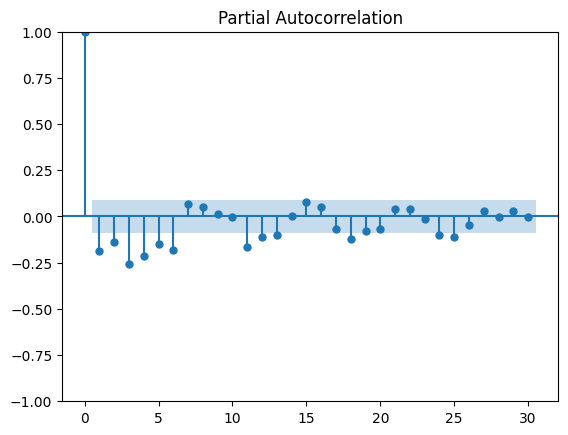

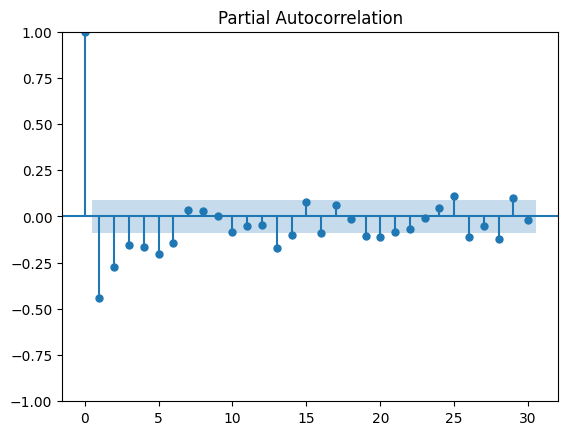

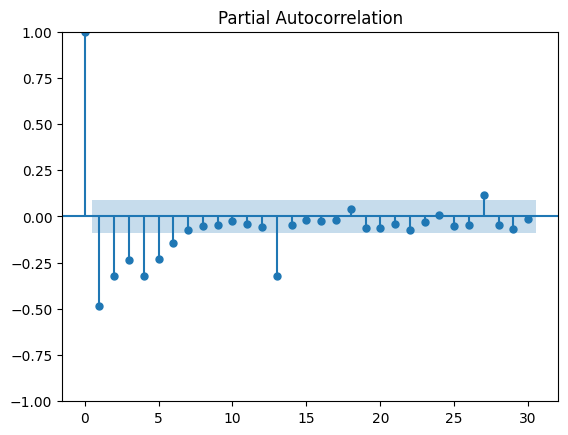

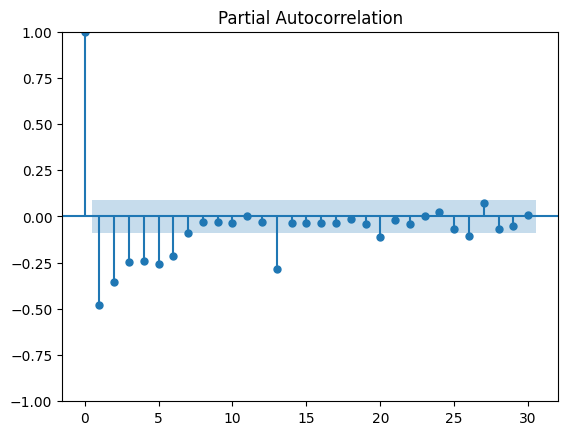

In [6]:
# Determine lags
plot_pacf(merged_df_diff["negative_news"], method = "ols", lags = 30)
plt.show()
## lag 6 

plot_pacf(merged_df_diff["positive_news"], method = "ols", lags = 30)
plt.show()
## lag 6

plot_pacf(merged_df_diff["negative_debate"], method = "ols", lags = 30)
plt.show()
## lag 6 

plot_pacf(merged_df_diff["positive_debate"], method = "ols", lags = 30)
plt.show()
## lag 6 

In [7]:
corr = merged_df['negative_news'].corr(merged_df['negative_debate'], method='pearson')
pp(corr)

corr = merged_df['positive_news'].corr(merged_df['positive_debate'], method='pearson')
pp(corr)

corr = merged_df['positive_news'].corr(merged_df['negative_debate'], method='pearson')
pp(corr)

corr = merged_df['negative_news'].corr(merged_df['positive_debate'], method='pearson')
pp(corr)

0.2010462003350734
0.19223288490086565
0.15989467549494132
0.2006961756878223


In [8]:
model = VAR(merged_df_diff)
model_fit = model.fit(maxlags=6, ic="aic")
model_fit.summary()

/home/debian/miniconda3/envs/debates/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 09, May, 2023
Time:                     08:33:44
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    13.3552
Nobs:                     457.000    HQIC:                   12.8081
Log likelihood:          -5339.24    FPE:                    256033.
AIC:                      12.4526    Det(Omega_mle):         206906.
--------------------------------------------------------------------
Results for equation negative_news
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.045366         0.293331            0.155           0.877
L1.negative_news          -0.413866         0.049845           -8.303           0.000
L1.positive_news           0.189

In [9]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# get only significant p-values
model_pvalues = model_fit.pvalues

print(model_pvalues.columns)
print(model_pvalues.shape)

model_pvalues = model_pvalues.melt(value_vars=model_pvalues.columns, var_name = "y_variable", value_name = "pvalue", ignore_index=False)

print(model_pvalues.head())


model_pvalues = model_pvalues[model_pvalues["pvalue"] < 0.05]
model_pvalues.index.name = "x_variable" 

print(model_pvalues)
print(model_pvalues.shape)

Index(['negative_news', 'positive_news', 'negative_debate', 'positive_debate'], dtype='object')
(25, 4)
                       y_variable  pvalue
const               negative_news   0.877
L1.negative_news    negative_news   0.000
L1.positive_news    negative_news   0.047
L1.negative_debate  negative_news   0.047
L1.positive_debate  negative_news   0.573
                         y_variable  pvalue
x_variable                                 
L1.negative_news      negative_news   0.000
L1.positive_news      negative_news   0.047
L1.negative_debate    negative_news   0.047
L2.negative_news      negative_news   0.000
L2.negative_debate    negative_news   0.001
L2.positive_debate    negative_news   0.021
L3.negative_news      negative_news   0.000
L3.positive_news      negative_news   0.006
L3.negative_debate    negative_news   0.048
L4.negative_news      negative_news   0.000
L5.negative_news      negative_news   0.001
L5.negative_debate    negative_news   0.032
L5.positive_debate    negati

In [10]:
sorted_order=model.select_order(maxlags=6)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       14.42       14.46   1.839e+06       14.44
1       13.57       13.75   7.832e+05       13.64
2       13.16       13.49   5.194e+05       13.29
3       12.95       13.41   4.189e+05       13.13
4       12.71      13.32*   3.311e+05       12.95
5       12.60       13.36   2.959e+05       12.90
6      12.45*       13.36  2.560e+05*      12.81*
-------------------------------------------------


In [11]:
model_fit.test_normality()
print(str(model_fit.test_normality()))

print(str(model_fit.test_whiteness(nlags=7)))

<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: reject at 5% significance level. Test statistic: 160761.651, critical value: 15.507>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.WhitenessTestResults object. H_0: residual autocorrelation up to lag 7 is zero: reject at 5% significance level. Test statistic: 106.621, critical value: 26.296>, p-value: 0.000>


In [12]:
# Granger causality
print("Do neg debates cause neg news?")
granger_news = grangercausalitytests(merged_df_diff[['negative_news', 'negative_debate']], 2)

print("\nDoes neg news cause neg debates?")
granger_debates = grangercausalitytests(merged_df_diff[['negative_debate', 'negative_news']], 6)

Do neg debates cause neg news?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.0583 , p=0.0003  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=13.1436 , p=0.0003  , df=1
likelihood ratio test: chi2=12.9601 , p=0.0003  , df=1
parameter F test:         F=13.0583 , p=0.0003  , df_denom=459, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.9933 , p=0.0000  , df_denom=456, df_num=2
ssr based chi2 test:   chi2=36.3811 , p=0.0000  , df=2
likelihood ratio test: chi2=35.0169 , p=0.0000  , df=2
parameter F test:         F=17.9933 , p=0.0000  , df_denom=456, df_num=2

Does neg news cause neg debates?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8233  , p=0.0511  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=3.8483  , p=0.0498  , df=1
likelihood ratio test: chi2=3.8324  , p=0.0503  , df=1
parameter F test:         F=3.8233  , p=0.0511  , df_denom=459, df_num=1

Granger Causality
number of 

In [13]:
# Granger causality 
print("Do pos debates cause pos news?")
granger_news = grangercausalitytests(merged_df_diff[['positive_news', 'positive_debate']], 2)
print("\nDo neg debates cause pos news?")
granger_news = grangercausalitytests(merged_df_diff[['positive_news', 'negative_debate']], 2)


print("\nDoes neg news cause pos debates?")
granger_debates = grangercausalitytests(merged_df_diff[['positive_debate', 'negative_news']], 6)

Do pos debates cause pos news?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0460  , p=0.8302  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=0.0463  , p=0.8296  , df=1
likelihood ratio test: chi2=0.0463  , p=0.8296  , df=1
parameter F test:         F=0.0460  , p=0.8302  , df_denom=459, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3427  , p=0.0972  , df_denom=456, df_num=2
ssr based chi2 test:   chi2=4.7368  , p=0.0936  , df=2
likelihood ratio test: chi2=4.7127  , p=0.0948  , df=2
parameter F test:         F=2.3427  , p=0.0972  , df_denom=456, df_num=2

Do neg debates cause pos news?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4046  , p=0.5250  , df_denom=459, df_num=1
ssr based chi2 test:   chi2=0.4072  , p=0.5234  , df=1
likelihood ratio test: chi2=0.4071  , p=0.5235  , df=1
parameter F test:         F=0.4046  , p=0.5250  , df_denom=459, df_num=1

Granger Causality
number of la

FEVD for negative_news
     negative_news  positive_news  negative_debate  positive_debate
0         1.000000       0.000000         0.000000         0.000000
1         0.944852       0.009314         0.045293         0.000540
2         0.933414       0.011788         0.045742         0.009057
3         0.910064       0.017594         0.062344         0.009998
4         0.889411       0.030926         0.069167         0.010496
5         0.881617       0.031060         0.076866         0.010457
6         0.875699       0.033699         0.076441         0.014161

FEVD for positive_news
     negative_news  positive_news  negative_debate  positive_debate
0         0.089442       0.910558         0.000000         0.000000
1         0.063259       0.923572         0.004792         0.008378
2         0.063529       0.919427         0.006612         0.010432
3         0.063659       0.917233         0.008412         0.010696
4         0.067563       0.909109         0.011793         0.011535
5

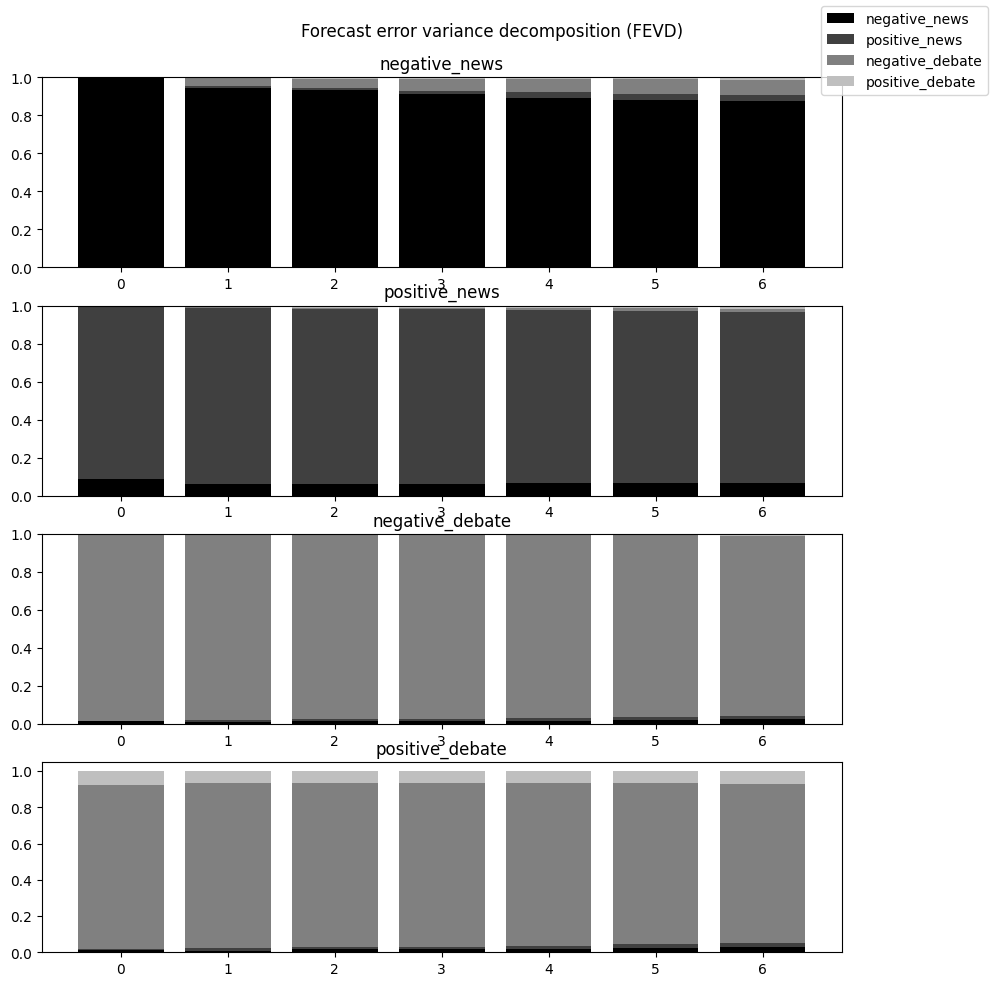

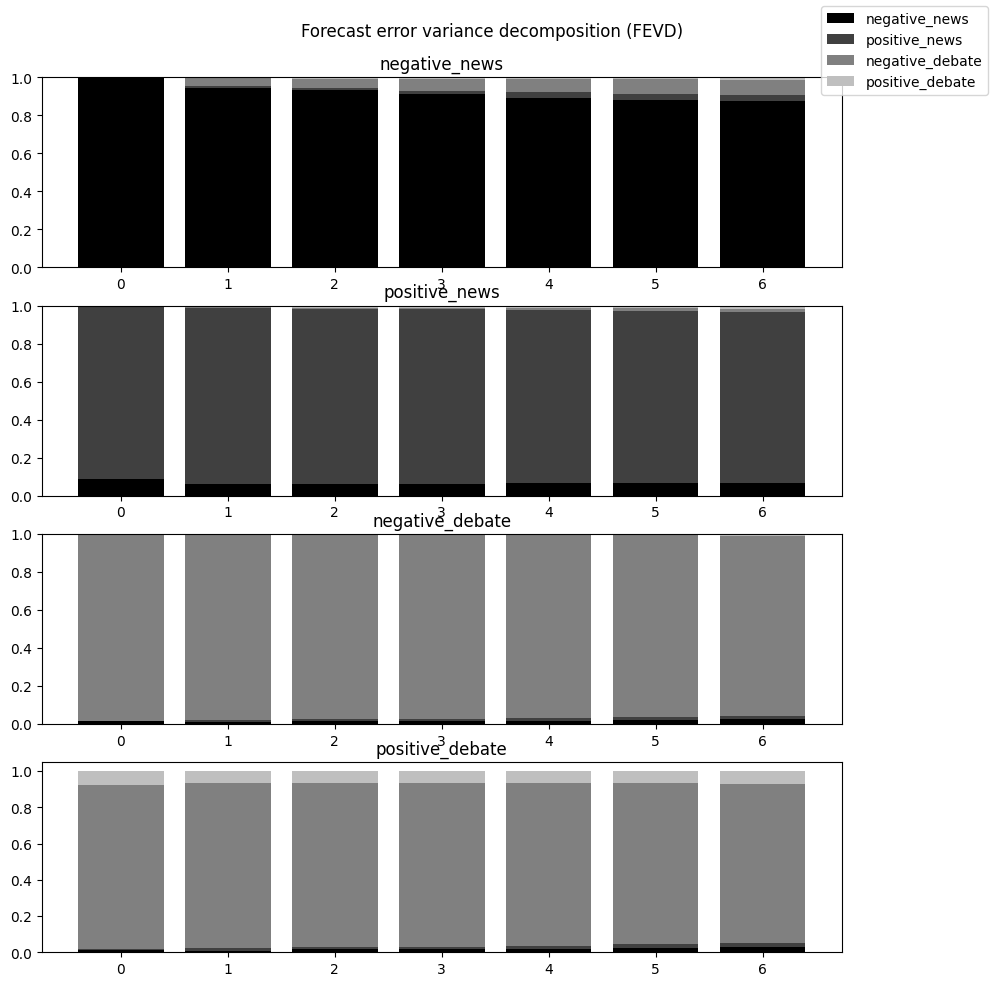

In [14]:
fevd = model_fit.fevd(7)
fevd.summary()

model_fit.fevd(7).plot()